<p dir=rtl style="direction: rtl;text-align: center;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=5>
    <b>پروژه سوم درس مباحثی در علوم کامیوتر: پیاده سازی Encoder Decoder </b><br>
    گروه 16: مهدی غیاثی، سینا ارزبین، نیما ابراهیمی
</font>    
</p>


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    <b>معرفی دیتاست</b><br>
    دیتاست MNIST شامل 60000 تصویر 28*28 پیکسلی از اعداد دستنویس می‌باشد که بیشتر برای تست الگوریتم های یادگیری ماشین استفاده می‌شود. این دیتاست شامل دو بخش آموزشی و تست می باشد که به ترتیب شامل 60000 و 10000 تصویر می‌باشند. هر تصویر یک عدد از 0 تا 9 را نشان می‌دهد.
    <br>
    این مجموعه داده ها را از از مجموعه داده های Pytorch دریافت می کنیم. از 
    هنگام دریافت مجموعه داده از متد 
    transforms.ToTensor() 
    نیز استفاده می کنیم تا تصاویر به تنسور تبدیل شوند.
</font>
</p>

In [2]:
# mnist dataset
mnist_train = datasets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor(), download=True)


<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    <b>مثالی از داده های موجود در دیتاست</b><br>
    در این قسمت 20 تصویر از دیتاست آموزشی را نمایش می دهیم.
</font>

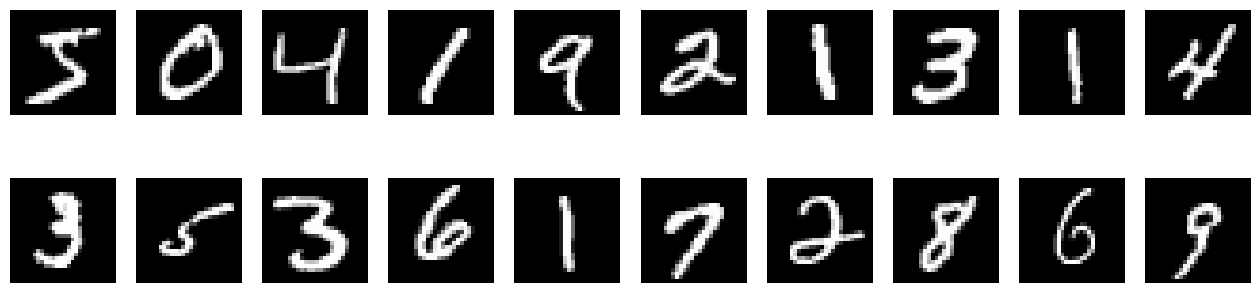

In [3]:
fig, axes = plt.subplots(2, 10, figsize=(16, 4))

for i in range(2):
    for j in range(10):
        axes[i, j].imshow(np.array(mnist_train.data[i*10+j]), cmap='gray')
        axes[i, j].axis('off')
plt.show()

<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    <b>ابر پارامترهای مدل</b><br>
    در این قسمت ابر پارامترهای مدل را تعریف می کنیم. این ابر پارامترها شامل اندازه بچ، نرخ یادگیری و تعداد ایپاک‌ها می‌باشند.
</font>

In [4]:
# hyperparameters
batch_size = 32
learning_rate = 1e-3
num_epoches = 4

<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    <b>دیتا لودرها</b><br>
    در این قسمت برای مجموعه داده‌های آموزشی و تست دیتا لودرها تعریف می‌کنیم. دیتا لودرها با دریافت مجموعه داده و اندازه بچ، داده‌ها را به صورت شافل برای یادگیری و تست به مدلی که در ادامه تعریف می‌کنیم می‌دهند.
</font>

In [5]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    <b>تعریف مدل</b><br>
    در این قسمت مدل خود را تعریف می‌کنیم. این مدل شامل یک
    Encoder
    و یک
    Decoder
    می‌باشد که در کانستراکتور مدل ساخته می‌شوند.
    همچنین کلاس مدل از کلاس
    nn.Module
    ارث بری می‌کند تا خواص مدل‌های
    Pytorch
    را نیز داشته باشد.<br>
    در بخش کدگذار از چهار لایه کانولوشنال به همراه تابع فعال ساز 
    ReLU
    استفاده کرده‌ایم. از آنجایی که با پدیگ و طول گامی که برای لایه‌های کانولوشنال در نظر گرفته‌ایم ابعاد تنسور ها تغییری نمی‌کند(فقط تعداد کانال ها توسط این لایه‌ها افزایش می‌یابد) پس از هر لایه کانولوشنال یک لایه پولینگ(مکس پولینگ) نیز قرار داده‌ایم تا سایز تصویر کاهش یابد. به طور کلی بخش کدگذار تنسور ورودی 
    28 * 28 * 1
    یی را به یک تنسور 
    1 * 1 * 64
    تبدیل می‌کند.<br>
    در بخش کدگشا از چهار لایه ترانسپوز کانولوشنال به همراه تابع فعال ساز ReLU
    استفاده کرده‌ایم. این بخش نیز تنسور ورودی با ابعاد
    1 * 1 * 64
    را به یک تنسور با ابعاد 
    1 * 28 * 28
    تبدیل می‌کند.<br>
    بخش میانی مدل که بین لایه کانولوشنال ها و لایه ترانسپوز کانولوشنال ها قرار دارد، به عنوان فضای لاتنت شناخته می شود.
    این بخش را بعد از انکود کردن تصویر می توان به عنوان نمایش فشرده تصویر دانست.
    در تابع forward این لایه میانی را نیز برمی گردانیم تا بتوانیم از آن برای نمایش تصاویر استفاده کنیم.
    
</font>


In [6]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
     
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=1, padding=1), # 28 * 28 -> 28 * 28
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 28 * 28 -> 14 * 14
            nn.Conv2d(32, 64, 3, stride=1, padding=1), # 14 * 14 -> 14 * 14
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 14 * 14 -> 7 * 7
            nn.Conv2d(64, 64, 3, stride=1, padding=1), # 7 * 7 -> 7 * 7
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 7 * 7 -> 3 * 3
            nn.Conv2d(64, 64, 3, stride=1, padding=1), # 3 * 3 -> 3 * 3
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 3 * 3 -> 1 * 1
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 3, stride=2), 
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 4, stride=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2), 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, stride=2), 
            nn.ReLU()
        )
        
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        lsr = self.encode(x)
        return self.decode(lsr), lsr
    
    def __call__(self, x):
        return self.forward(x)

<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    <b>ایجاد مدل</b><br>
    مدل را در این قسمت ایجاد می کنیم.<br>
    همچنین یک بهینه ساز Adam
    نیز برای بهینه سازی مدل تعریف می‌کنیم.
    هنگام تعریف بهینه ساز نیز پارامتر‌های مدل و لرنینگ ریت مورد نظرمان را به عنوان پارامتر به آن می‌دهیم.
    
</font>

   

In [7]:
# define model
model = AutoEncoder()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    <b>نمایش تصاویر</b><br>
    در این قسمت چند تصویر از مجموعه داده تست را به همراه تصویر فضای لاتنت آن‌ها و تصویر بازسازی شده آن‌ها توسط مدل را نمایش می دهیم.
    توجه شود که در این بخش هنوز مدل آموزش ندیده است و تصاویر با استفاده از مدل آموزش نیافته بازسازی شده اند.
    <br>
</font>

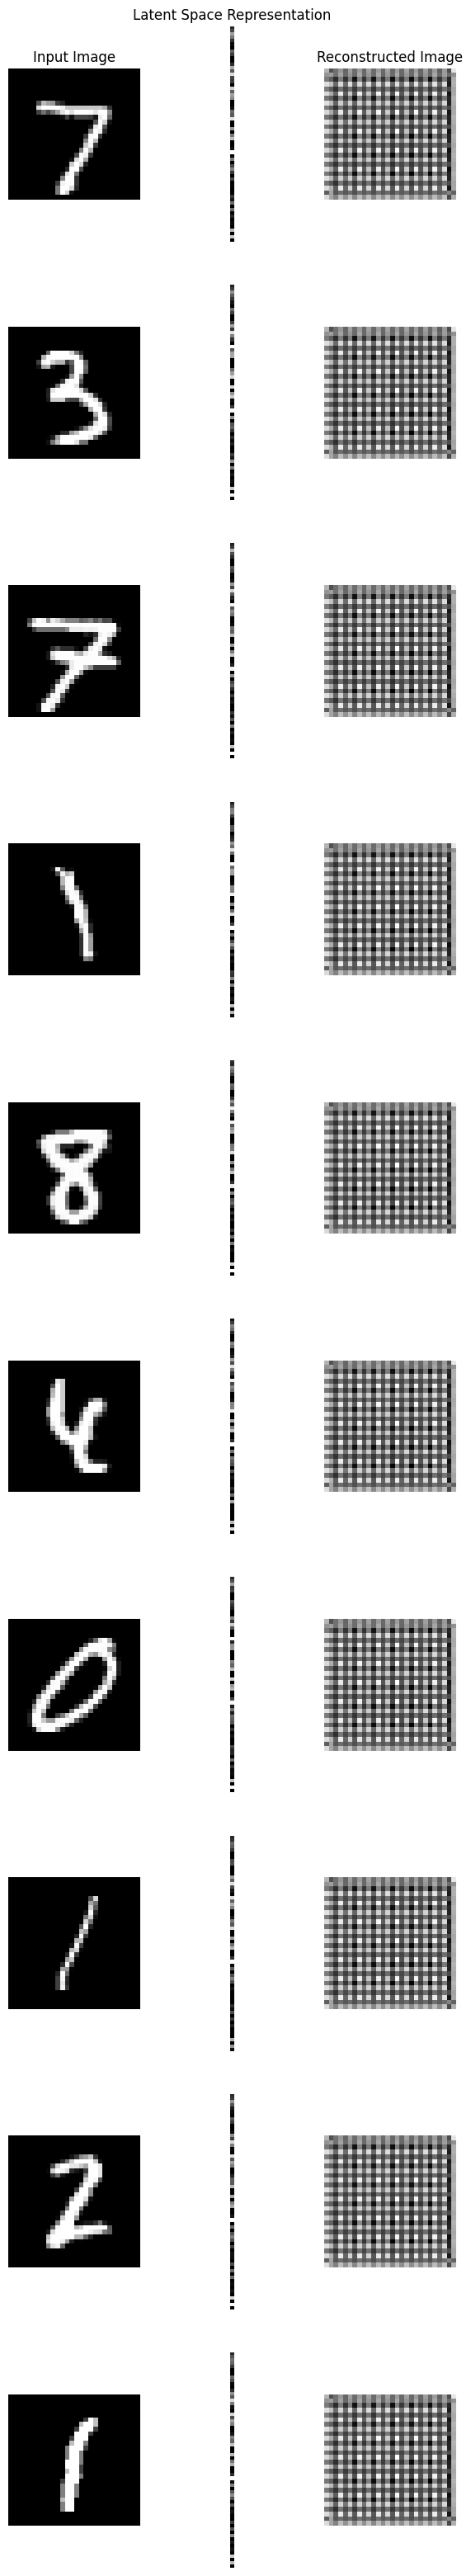

In [8]:
input_images = []
lsr_images = []
output_images = []

for batch_idx, (data, _) in enumerate(test_loader):
    input_images.append(data[0])
    
    recon_image, lsr_image = model(data[0])
    lsr_image = lsr_image.view(1, 64, 1)
    lsr_images.append(lsr_image.detach())
    output_images.append(recon_image.detach())
    
    if batch_idx == 10:
        break
        
fig, axes = plt.subplots(10, 3, figsize=(7, 40))
axes[0, 0].set_title('Input Image')
axes[0, 1].set_title('Latent Space Representation')
axes[0, 2].set_title('Reconstructed Image')
for j in range(10):
    axes[j, 0].imshow(np.array(input_images[j][0]), cmap='gray')
    axes[j, 1].imshow(np.array(lsr_images[j][0]), cmap='gray')
    axes[j, 2].imshow(np.array(output_images[j][0]), cmap='gray')
    axes[j, 0].axis('off')
    axes[j, 1].axis('off')
    axes[j, 2].axis('off')

In [9]:
test_image = mnist_test.data[0]
test_over_batches = [test_image]
test_image = test_image.view(1, 1, 28, 28).float()
recon_image, lsr_image = model(test_image)
test_over_batches.append(recon_image.view(28, 28).detach())

<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    <b>آموزش مدل</b><br>
    در این قسمت مدل را آموزش می دهیم. برای این کار از تابع خطای
     MSE
      استفاده می کنیم. 
    در هر ایپاک ابتدا گاردیان‌های پارامترها توسط بهینه ساز صفر می‌شود سپس برای هر بچ از تصاویر که توسط دیتالودر به ما داده می‌شود، بچ تصاویر با استفاده از مدل بازسازی می‌شود و خطای کل بچ تصاویر با تصاویر اصلی محاسبه می شود.
    سپس بر روی تنسور مقدار خطا
    backward
    می‌زنیم تا گرادیان تمام پارامترهای مدل بروزرسانی شود.
    پس از آن متد 
    step
    بهینه ساز را فرخوانی می‌کنیم تا پارامترهای مدل بروزرسانی شوند.
</font>

In [10]:
# train model
loss_func = nn.MSELoss()

for epoch in range(1, num_epoches + 1):
    train_loss = 0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batches, _ = model(data)
        
        recon_image, lsr_image = model(test_image)
        test_over_batches.append(recon_image.view(28, 28).detach())
        
        loss = loss_func(recon_batches, data)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.003264
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.001827
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.001160
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.000981
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.000635
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.000599
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.000668
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.000531
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.000595
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.000432
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.000412
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.000395
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.000344
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.000336
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.000356
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.000413
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.000285
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.000311
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.000323
====> Epoch: 1 Average loss: 0.0006
Train Epoch: 2 [0/60000

<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    <b>نمایش پیشرفت مدل طی آموزش دیدن در جهت درست دیکود کردن</b><br>
    در این قسمت خروجی مدل را با یک ورودی خاص در طی آموزش در ایپاک اول نمایش می دهیم.
    این نمایش نشان می دهد که مدل چقدر در جهت درست دیکود کردن تصاویر پیشرفت کرده است.
    طبیعی است که در ابتدا تصاویر با استفاده از مدل بازسازی شده نامناسب باشند اما با گذشت زمان و آموزش مدل، تصاویر بازسازی شده به تصاویر ورودی شبیه تر می شوند.
</font>
    

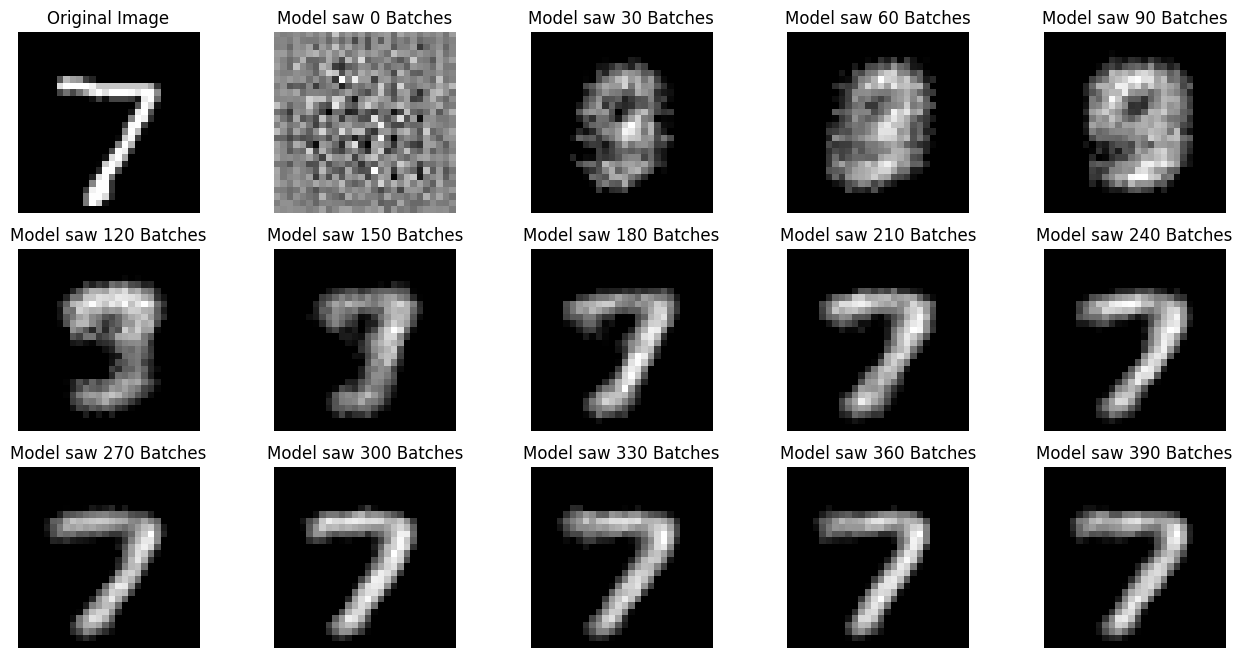

In [15]:
# show the reconstructed image
fig, axes = plt.subplots(3, 5, figsize=(16, 8))
for i in range(3):
    for j in range(5):
        if i == 0 and j == 0:
            axes[i, j].set_title('Original Image')
            axes[i, j].imshow(np.array(test_over_batches[i*150+j*30]), cmap='gray')
        else:
            axes[i, j].set_title(f'Model saw {i*150+(j-1)*30} Batches')
            axes[i, j].imshow(np.array(test_over_batches[i*150+(j)*30 - 29]), cmap='gray')
        axes[i, j].axis('off')


<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    <b>نمایش تصاویر پس از آموزش مدل</b><br>
    در این قسمت تصاویری که قبل از آموزش مدل نمایش داده بودیم را به همراه تصویر فضای لاتنت آن‌ها و تصویر بازسازی شده آن‌ها توسط مدل را نمایش می دهیم.
    در این بخش مدل آموزش دیده است و همانطور که قابل مشاهده است خروجی مدل بسیار نزدیک به تصویر ورودی می‌باشد.
    <br>
</font>

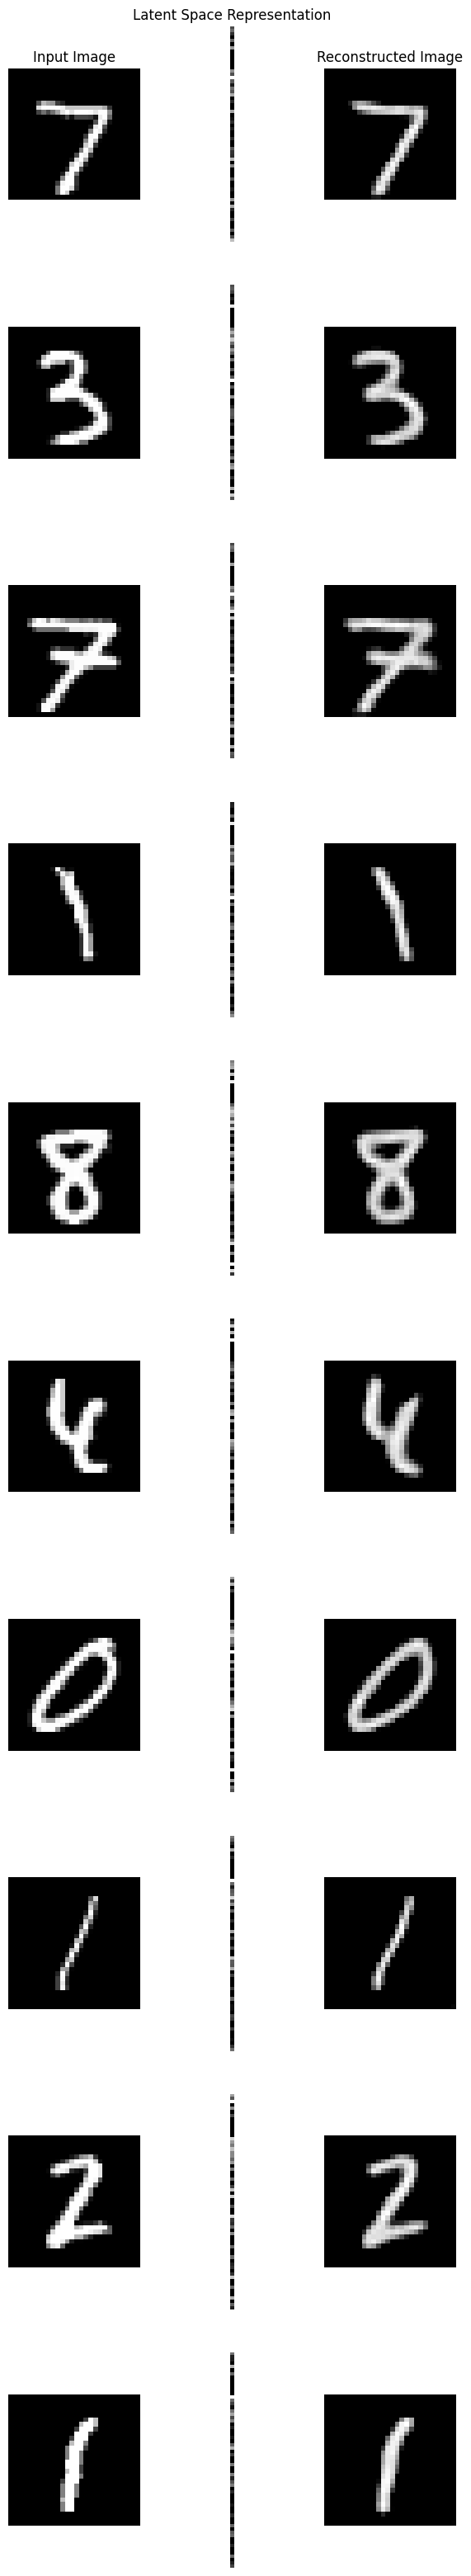

In [12]:
input_images = []
lsr_images = []
output_images = []

for batch_idx, (data, _) in enumerate(test_loader):
    input_images.append(data[0])
    
    recon_image, lsr_image = model(data[0])
    lsr_image = lsr_image.view(1, 64, 1)
    lsr_images.append(lsr_image.detach())
    output_images.append(recon_image.detach())
     
    if batch_idx == 10:
        break
        
fig, axes = plt.subplots(10, 3, figsize=(7, 40))
axes[0, 0].set_title('Input Image')
axes[0, 1].set_title('Latent Space Representation')
axes[0, 2].set_title('Reconstructed Image')
for j in range(10):
    axes[j, 0].imshow(np.array(input_images[j][0]), cmap='gray')
    axes[j, 1].imshow(np.array(lsr_images[j][0]), cmap='gray')
    axes[j, 2].imshow(np.array(output_images[j][0]), cmap='gray')
    axes[j, 0].axis('off')
    axes[j, 1].axis('off')
    axes[j, 2].axis('off')